In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy
from PIL import Image
import math
from math import sqrt

from skimage.metrics import structural_similarity as ssim
import neptune
from tqdm import tqdm
import uuid

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# adding neptuneai integration for the run

#create a random runid for neptuneai run
run_id = str(uuid.uuid4())

# initialize a new neptuneai run
run = neptune.init_run(
    project="ImgResProject/ImageRes",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZTYxYWUwNi0zZWY0LTRkYWMtODA3Ny1lMDU0YTIyZTQ4YzQifQ==",
    tags=["ESPCN"],
    name="ESPCN-6"
)

# add the runid to neptuneai id
run["id"] = run_id

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-20


In [4]:
# for loading dataset
class SuperResolutionDataset(Dataset):
    def __init__(self, low_res_image_dir, high_res_image_dir, csv_file=None, image_data=None, transform=None):
        if image_data is not None:
            self.image_data = image_data
        elif csv_file is not None:
            self.image_data = pd.read_csv(csv_file)
        self.transform = transform
        self.fixed_size = (800, 1200)
        self.csv_file = csv_file
        self.high_res_image_dir = high_res_image_dir
        self.low_res_image_dir = low_res_image_dir

        if len(self.image_data) == 0:
            raise ValueError(f"No image files found in CSV file: {csv_file}")
        
        print(f"Found {len(self.image_data)} image pairs.")

    def __len__(self):
        return len(self.image_data)
    
    def train_val_test_split(self, r1, r2, r3):
        assert r1 + r2 + r3 == 1, "Ratios must sum to 1"
        
        train_data, temp_data = train_test_split(self.image_data, test_size=(1 - r1))
        val_data, test_data = train_test_split(temp_data, test_size=(r3 / (r2 + r3)))
        
        train_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=train_data.reset_index(drop=True),
                                               transform=self.transform)
        
        val_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=val_data.reset_index(drop=True),
                                               transform=self.transform)
        
        test_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=test_data.reset_index(drop=True),
                                               transform=self.transform)
        
        return train_dataset, val_dataset, test_dataset

    def __getitem__(self, index):
        # get image names in folders using index
        lr_image_path = self.image_data.iloc[index, 0]
        hr_image_path = self.image_data.iloc[index, 1]

        # add image path and convert it to RGB
        lr_img = Image.open(self.low_res_image_dir+lr_image_path).convert('RGB')
        hr_img = Image.open(self.high_res_image_dir+hr_image_path).convert('RGB')

        # resixe low res image to high res image size
        lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)

        #apply transform for both images
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        return lr_img, hr_img

In [5]:
# define resize and transform
transform = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Resize((384, 384), interpolation=Image.BICUBIC),
    transforms.ToTensor()
])

img_set_path = "image_dataset/Image Super Resolution - Unsplash/"

# load and apply transform to all images and map csv file mapping from low res to high res images
img_dataset = SuperResolutionDataset(csv_file=img_set_path+"image_data.csv",
                                     low_res_image_dir= img_set_path+"/low res/",
                                     high_res_image_dir= img_set_path+"/high res/",
                                     transform=transform)

Found 3762 image pairs.


/scratch/16353640/ipykernel_304200/1864039461.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((384, 384), interpolation=Image.BICUBIC),
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [6]:
# split the dataset to train test and validation in ratio 70:15:15
train_dataset, val_dataset, test_dataset = img_dataset.train_val_test_split(0.7, 0.15, 0.15)

Found 2633 image pairs.
Found 564 image pairs.
Found 565 image pairs.


In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

2633
564
565


In [8]:
# Function to show lowres and high res images side by side
def show_tensorpair(tensor_pair):
    # convert to numpy for display
    lr_img = tensor_pair[0].cpu().numpy()
    hr_img = tensor_pair[1].cpu().numpy()
    # transpose the image reording the dimension from tensor to matplotlib use
    lr_img = lr_img.transpose(1,2,0)
    hr_img = hr_img.transpose(1,2,0)

    # display images using subplot
    fig, axs = plt.subplots(1, 2, figsize=(12, 20))
    axs[0].imshow(lr_img, cmap='gray')
    axs[0].set_title('Low-res Image')
    axs[0].axis('off')
    axs[1].imshow(hr_img, cmap='gray')
    axs[1].set_title('High-res Image')
    axs[1].axis('off')
    
    plt.show()

/scratch/16353640/ipykernel_304200/3442098758.py:55: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)


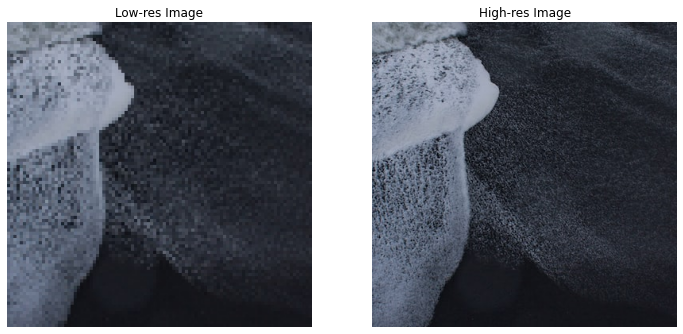

In [9]:
#display single sample image
show_tensorpair(train_dataset[22])
#train_dataset[0][2]

In [10]:
# creating dataloader for each dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
# defining n Efficient Sub-Pixel Convolutional Neural Network

class ESPCN(nn.Module):
    
    # ESPCN uses 3 convolution layers with tanh as activation function along with an additional pixel shuffle layer
    def __init__(self, scale_factor, num_channels=1):
        super(ESPCN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=5, padding=5//2),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=3//2),
            nn.Tanh(),
        )
        self.last_part = nn.Sequential(
            nn.Conv2d(32, num_channels * (scale_factor ** 2), kernel_size=3, padding=3 // 2),
            nn.PixelShuffle(scale_factor)
        )

    def forward(self, x):
        x = self.first_part(x)
        x = self.last_part(x)
        return x

In [12]:
# function to calculate psnr - given by 10 * log10(R/sqrt(MSE))
def calculate_psnr(img1, img2):
    # calculate MSE loss first
    mse = nn.functional.mse_loss(img1, img2)

    # if both images are same : mse will be zero - handle it
    if mse == 0:
        return float('inf')
    # Determine the maximum pixel value
    if img1.dtype == torch.uint8:
        max_pixel = 255.0
    elif img1.dtype == torch.float32:
        max_pixel = 1.0

    #psnr calculation formula = 10 * log10(R/sqrt(MSE)) where R is maximum pizel since we are dealing in float = it is 1.0
    return 10 * math.log10(1.0 / mse.item())


In [13]:
def calculate_ssim(img1, img2):

    # initialize required value to store ssim avlues for each image
    ssim_values = []
    batch_size= img1.shape[0]
    

    # iterate over each image in the batch
    for i in range(batch_size):

        # average SSIM values across channels
        opimg = np.transpose(img1[i].cpu().numpy(), (1, 2, 0))
        ogimg = np.transpose(img2[i].cpu().numpy(), (1, 2, 0))

        ssim_val = ssim(opimg, ogimg, channel_axis=-1, data_range=ogimg.max() - ogimg.min())
        # take mean of all channels as ssim value for the image
        ssim_values.append(np.mean(ssim_val))

    # if there are any nan values then make it 0.0
    ssim_values = [0.0 if np.isnan(x) else x for x in ssim_values]

    if np.isnan(np.mean(ssim_values)):
        print(ssim_values)

    # return avrage of all images in the batch and return it as ssim value of all images in the batch
    return np.mean(ssim_values)

In [31]:
import gc
def test_model(model, test_loader, img_cnt=5):
        
    #eval mode for validation
    model.eval()
    # calculating peak signal to noise ratio
    psnr = 0.0
    ssim = 0.0
    count=0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_img, hr_img = lr_imgs.to(device), hr_imgs.to(device)

            # apply tained model on lores image
            outputs = model(lr_img)
            # calculate psnr and add
            psnr += calculate_psnr(outputs, hr_img)
            ssim += calculate_ssim(outputs, hr_imgs)
            if count+1 <= img_cnt:
                count+=1
                print(count)
                display_compare_images(lr_img, hr_img, outputs)
            del lr_img, hr_img, outputs
            gc.collect()

    #calculate average psnr
    psnr = psnr / len(test_loader)
    ssim = ssim / len(test_loader)
    print(f'PSNR value for testing dataset is : {psnr}')
    print(f'SSIM value for testing dataset is : {ssim}')

    return 

In [15]:
def display_compare_images(lr, hr, op):

    itr = lr.size(0)
    # compare only low res and outputted super res images
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    
    for i in range(2):
        lrimg = lr[i].permute(1, 2, 0).cpu().numpy()
        opimg = op[i].permute(1, 2, 0).cpu().numpy()
        
        ax[i][0].imshow(lrimg)
        ax[i][0].set_title("Low res image")
        ax[i][0].axis('off')
        ax[i][1].imshow(opimg)
        ax[i][1].set_title("Super resolved image")
        ax[i][1].axis('off')
 
    
    plt.tight_layout()
    plt.show()


In [41]:
# # Directory to save model weights
# save_dir = 'ESPCNN_model_weights'
# os.makedirs(save_dir, exist_ok=True)

# # Function to save model weights
# def save_weights(epoch, model, save_dir, log = False):
#     if log == True:
#         model_path = os.path.join(save_dir, f'model_epoch.pth')
#     else:
#         model_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')
    
#     torch.save(generator.state_dict(), model_path)

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_epoch = -1
    max_psnr = 0.0
    max_ssim = 0.0
    train_loss = []
    psnr_values = []
    ssim_values = []
    max_psnr_weights = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        losssum = 0.0

        # Wrap the training loop with tqdm
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for lr_imgs, hr_imgs in train_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                
                optimizer.zero_grad()
                # Train the model 
                outputs = model(lr_imgs)
                # Calculate loss
                loss = criterion(outputs, hr_imgs)
                # Backpropagation
                loss.backward()
                optimizer.step()

                # Adding losses
                losssum += loss.item() * lr_imgs.size(0)

                # Update tqdm
                pbar.set_postfix(loss=loss.item())
                pbar.update()

        # Calculating average loss
        tl = losssum / len(train_loader.dataset)
        
        # Evaluation mode for validation
        model.eval()
        psnr = 0.0
        ssim = 0.0
        
        with torch.no_grad():
            for lr_imgs, hr_imgs in tqdm(val_loader, desc="Validation", unit="batch"):
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                                
                outputs = model(lr_imgs)
                psnr += calculate_psnr(outputs, hr_imgs)
                ssim += calculate_ssim(outputs, hr_imgs)
        
        psnr = psnr / len(val_loader)
        ssim = ssim / len(val_loader)
        
        # Append values to lists for plotting graphs
        train_loss.append(tl)
        psnr_values.append(psnr)
        ssim_values.append(ssim)
        
        run["train/loss"].append(tl)
        run["val/psnr"].append(psnr)
        run["val/ssim"].append(ssim)
        print(f'Epoch {epoch+1}, Loss: {tl}, PSNR: {psnr}, SSIM: {ssim}')

        # Check if the PSNR and SSIM have increased than the best we had
        if psnr > max_psnr and ssim > max_ssim:
            # Save the new weights and PSNR, SSIM
            max_psnr = psnr
            max_ssim = ssim
            max_psnr_weights = copy.deepcopy(model.state_dict())
    
    print(f'Maximum PSNR: {max_psnr} and corresponding SSIM: {max_ssim}')
    # Load the max PSNR weights into the model
    model.load_state_dict(max_psnr_weights)
    return model, psnr_values, ssim_values, train_loss

In [17]:
espcn_model = ESPCN(scale_factor=1, num_channels=3)
espcn_model = espcn_model.to(device)
best_weights = copy.deepcopy(espcn_model.state_dict())

best_epoch = 0
best_psnr = 0.0

learning_rate=0.0003

criterion = nn.MSELoss()
optimizer = optim.Adam([
        {'params': espcn_model.first_part.parameters()},
        {'params': espcn_model.last_part.parameters(), 'lr': learning_rate}
    ], lr=learning_rate)



In [18]:
params = {"learning_rate": learning_rate, "optimizer": "Adam", "Cropped image": True, "Crop specs": "Center, 384-384"}
run["parameters"] = params

In [19]:
import time
st = time.time()
# training the model
num_epochs = 100
trained_model, psnr_values,ssim_values, train_loss = train_model(espcn_model,train_loader,val_loader, criterion, optimizer, num_epochs=num_epochs)

# printing time taken to train model
print(f'Training took {(time.time()-st)/60} min')

Epoch 1/100:   0%|          | 0/165 [00:00<?, ?batch/s]/scratch/16353640/ipykernel_304200/3442098758.py:55: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)
Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 1, Loss: 0.014244133323583819, PSNR: 23.300857317271088, SSIM: 0.7210566831959618


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 2, Loss: 0.004738829679966844, PSNR: 23.983434839542447, SSIM: 0.744916804962688


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 3, Loss: 0.0042370312889288735, PSNR: 24.407959352355746, SSIM: 0.7610540671481026


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 4, Loss: 0.003924181864979266, PSNR: 24.72611696855148, SSIM: 0.7708236260546578


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 5, Loss: 0.0037290735074389336, PSNR: 24.868317741347486, SSIM: 0.7753089583582349


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 6, Loss: 0.003630236111138479, PSNR: 24.988797367511957, SSIM: 0.783911461631457


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.58batch/s]


Epoch 7, Loss: 0.0035203267050679934, PSNR: 25.012424290222796, SSIM: 0.7783568683597777


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 8, Loss: 0.0034802016799302437, PSNR: 25.132228429402982, SSIM: 0.7892143030961355


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.58batch/s]


Epoch 9, Loss: 0.0034617710104470375, PSNR: 25.15615236824933, SSIM: 0.7932038323746787


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.58batch/s]


Epoch 10, Loss: 0.0034429716261385303, PSNR: 25.17803017535865, SSIM: 0.7921696205933889


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.58batch/s]


Epoch 11, Loss: 0.003424863841248824, PSNR: 25.258875720019518, SSIM: 0.7934781180487739


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.58batch/s]


Epoch 12, Loss: 0.0034168606446797725, PSNR: 25.26649420457876, SSIM: 0.7987514701154497


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 13, Loss: 0.0033972950558861853, PSNR: 25.249678152850272, SSIM: 0.7972389890087975


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 14, Loss: 0.0034058963369006526, PSNR: 25.29008619571995, SSIM: 0.7960765494240655


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 15, Loss: 0.0034010263488027013, PSNR: 25.230519821154274, SSIM: 0.795402510298623


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 16, Loss: 0.003388311396212523, PSNR: 25.292654617157346, SSIM: 0.7989526473813586


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 17, Loss: 0.0034480612826534676, PSNR: 25.30654758222698, SSIM: 0.7982997745275497


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 18, Loss: 0.0033761624985120193, PSNR: 25.311033384521906, SSIM: 0.7958349833885828


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 19, Loss: 0.003406464359134102, PSNR: 25.271838347438017, SSIM: 0.7968379308780035


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 20, Loss: 0.0033758672375544664, PSNR: 25.310945892657173, SSIM: 0.7985580811897913


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 21, Loss: 0.0033690979321544905, PSNR: 25.330707184144515, SSIM: 0.7991558611392975


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 22, Loss: 0.0033694440810214284, PSNR: 25.30266252425126, SSIM: 0.7965025868680742


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 23, Loss: 0.0033699038049062532, PSNR: 25.321698346638108, SSIM: 0.7972329755624136


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 24, Loss: 0.0033825499833654506, PSNR: 25.31548821889624, SSIM: 0.7992463376786973


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 25, Loss: 0.0033607522471911537, PSNR: 25.33941198209172, SSIM: 0.8001341587967343


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 26, Loss: 0.003361050401376741, PSNR: 25.328872766711466, SSIM: 0.8001718057526482


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 27, Loss: 0.0033780988005152274, PSNR: 25.34038869091926, SSIM: 0.7987725817494922


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 28, Loss: 0.0033973788876515173, PSNR: 25.34104377802866, SSIM: 0.7995459073119693


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 29, Loss: 0.0033814111504133575, PSNR: 25.345183573577334, SSIM: 0.8003251122103797


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 30, Loss: 0.0033565007201107654, PSNR: 25.34346589638446, SSIM: 0.7997479836146036


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 31, Loss: 0.003359173402523405, PSNR: 25.27250832588991, SSIM: 0.7969836973481708


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.57batch/s]


Epoch 32, Loss: 0.0033689195566456603, PSNR: 25.31630321896376, SSIM: 0.8003791189856


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 33, Loss: 0.0033666179220072224, PSNR: 25.34448887116089, SSIM: 0.7982763515578376


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 34, Loss: 0.0033919245373486675, PSNR: 25.327668442348568, SSIM: 0.8005227512783475


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 35, Loss: 0.003352828555522176, PSNR: 25.34289120302773, SSIM: 0.8003589610258738


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 36, Loss: 0.003354072782674014, PSNR: 25.30001486762665, SSIM: 0.7985475096437666


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 37, Loss: 0.0033504665564665016, PSNR: 25.3506766783044, SSIM: 0.7975495805342993


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 38, Loss: 0.003357871245993234, PSNR: 25.31030060791376, SSIM: 0.7983470459779104


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 39, Loss: 0.0033582717024088415, PSNR: 25.261943747849163, SSIM: 0.793571424153116


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 40, Loss: 0.003359060286534713, PSNR: 25.329574773982568, SSIM: 0.7990169260236952


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 41, Loss: 0.0033556722891380803, PSNR: 25.349198645606034, SSIM: 0.79815783434444


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 42, Loss: 0.0033436124820539503, PSNR: 25.32078985511216, SSIM: 0.8000120636489656


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 43, Loss: 0.003369138435843697, PSNR: 25.343537701920255, SSIM: 0.7994330906205707


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 44, Loss: 0.0033506224536047975, PSNR: 25.352694415024047, SSIM: 0.8022907144493527


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 45, Loss: 0.0033566127440149717, PSNR: 25.35690389868885, SSIM: 0.8004335082239575


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 46, Loss: 0.003394686662232269, PSNR: 25.315427760830786, SSIM: 0.7984761397043864


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 47, Loss: 0.003342072626924587, PSNR: 25.25282737319532, SSIM: 0.7970878514978621


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 48, Loss: 0.0033536865299888044, PSNR: 25.240557534090993, SSIM: 0.7962731801801257


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 49, Loss: 0.0033629733846801237, PSNR: 25.247200294264932, SSIM: 0.7929362605015436


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 50, Loss: 0.003363776139508575, PSNR: 25.35449546778385, SSIM: 0.8007298062245051


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 51, Loss: 0.003339073999384839, PSNR: 25.35254113922899, SSIM: 0.7953615287939707


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 52, Loss: 0.003336981830795172, PSNR: 25.36590847601334, SSIM: 0.7994223054912355


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 53, Loss: 0.003344961081444368, PSNR: 25.34345887373427, SSIM: 0.7986176129844453


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 54, Loss: 0.003363246141269342, PSNR: 25.271238691673048, SSIM: 0.7963811390929751


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 55, Loss: 0.003336095354692042, PSNR: 25.36502518195502, SSIM: 0.7963577856620153


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 56, Loss: 0.003346335693314513, PSNR: 25.22346790781278, SSIM: 0.7997500515646405


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 57, Loss: 0.003365673034063173, PSNR: 25.371771409186742, SSIM: 0.7994126611285739


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 58, Loss: 0.0033677204385077235, PSNR: 25.166673811135684, SSIM: 0.7969832039541669


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 59, Loss: 0.0033895266277696465, PSNR: 25.375083642850935, SSIM: 0.8004387186633216


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 60, Loss: 0.0033335649233135973, PSNR: 25.31769996125312, SSIM: 0.7993807461526659


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 61, Loss: 0.0033418386060414863, PSNR: 25.23289561878831, SSIM: 0.8042723288138708


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 62, Loss: 0.003340144624586609, PSNR: 25.359397265627877, SSIM: 0.7967119862635931


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 63, Loss: 0.003330790939144125, PSNR: 25.361258075298093, SSIM: 0.8025390952825546


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 64, Loss: 0.0033462885604514125, PSNR: 25.369449285442546, SSIM: 0.7984764526287714


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.57batch/s]


Epoch 65, Loss: 0.003329552044724834, PSNR: 25.378531596895744, SSIM: 0.800729696949323


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 66, Loss: 0.003336357696376602, PSNR: 25.365723472543742, SSIM: 0.796744833389918


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 67, Loss: 0.0033278737862357795, PSNR: 25.37698570797406, SSIM: 0.8005664398272833


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 68, Loss: 0.003334380524813778, PSNR: 25.30549877324829, SSIM: 0.7944037550025516


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 69, Loss: 0.003331768803441373, PSNR: 25.39148748779853, SSIM: 0.8013488368855582


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 70, Loss: 0.0033498883548560895, PSNR: 25.34172338657318, SSIM: 0.7984206560585234


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 71, Loss: 0.0033254548751646875, PSNR: 25.31372467713844, SSIM: 0.7982188396983676


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 72, Loss: 0.003339600345905781, PSNR: 25.33812788785588, SSIM: 0.7993864466746649


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 73, Loss: 0.0033314765725982335, PSNR: 25.343829309616495, SSIM: 0.7935885853237576


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 74, Loss: 0.003334899377424455, PSNR: 25.37592090298554, SSIM: 0.8005940152539147


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 75, Loss: 0.0033405716824559287, PSNR: 25.368120406236596, SSIM: 0.8017856876055399


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 76, Loss: 0.0033408899827263583, PSNR: 25.374654631162404, SSIM: 0.8000792612632116


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 77, Loss: 0.0033327953495931317, PSNR: 25.304259988993817, SSIM: 0.8000458247131772


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 78, Loss: 0.003337708189715644, PSNR: 25.280198396107178, SSIM: 0.7968192365434434


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 79, Loss: 0.0033320242915220455, PSNR: 25.392272903903617, SSIM: 0.8015185743570328


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 80, Loss: 0.0033304316031580673, PSNR: 25.381913967084976, SSIM: 0.8027077201339934


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 81, Loss: 0.0033226344346055006, PSNR: 25.387007791343663, SSIM: 0.8043926424450345


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 82, Loss: 0.003339811281891426, PSNR: 25.39328673651056, SSIM: 0.8022696955336465


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 83, Loss: 0.0033419966055087368, PSNR: 25.385546448886934, SSIM: 0.8028373254670037


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 84, Loss: 0.003329788917938068, PSNR: 25.3818256899486, SSIM: 0.7992721680137846


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 85, Loss: 0.0033378699319377013, PSNR: 25.333914704727306, SSIM: 0.7968436628580093


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 86, Loss: 0.003322021516690443, PSNR: 25.398041986421514, SSIM: 0.8009923249483109


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.57batch/s]


Epoch 87, Loss: 0.0033350980630518705, PSNR: 25.25503631000854, SSIM: 0.7980962014860578


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 88, Loss: 0.003353328103881557, PSNR: 25.351715815465102, SSIM: 0.8001876771450043


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 89, Loss: 0.0033240428923403203, PSNR: 25.385879276779022, SSIM: 0.8041062437825732


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 90, Loss: 0.0033251238325232284, PSNR: 25.36287386604432, SSIM: 0.7897606690724691


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 91, Loss: 0.0033333957338712024, PSNR: 25.34851783231788, SSIM: 0.7955854402648078


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 92, Loss: 0.00332406315355828, PSNR: 25.338986866373705, SSIM: 0.7998349385129081


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 93, Loss: 0.0033356174438423556, PSNR: 25.38624227299259, SSIM: 0.802926265531116


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 94, Loss: 0.0033333337105466835, PSNR: 25.370806240113424, SSIM: 0.7965590953826904


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 95, Loss: 0.0033217772199113332, PSNR: 25.392878190296077, SSIM: 0.7998687442806032


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 96, Loss: 0.003321650854506071, PSNR: 25.324779823759403, SSIM: 0.795808290441831


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 97, Loss: 0.0033331138523634376, PSNR: 25.22433957650996, SSIM: 0.7997976193825403


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 98, Loss: 0.003321497329357591, PSNR: 25.373494313965463, SSIM: 0.8024256312184863


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 99, Loss: 0.003320278310080077, PSNR: 25.392679072780634, SSIM: 0.8019313083754646


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]

Epoch 100, Loss: 0.0033243459324323087, PSNR: 25.30742841700838, SSIM: 0.8008676187859641
Maximum PSNR: 25.387007791343663 and corresponding SSIM: 0.8043926424450345
Training took 132.5701487382253 min


In [20]:
# save the max psnr  model weights
pthname = "max_psnr_espcn"+str(time.time())+".pth"
torch.save(trained_model.state_dict(), pthname)

# add this to neptuneai log
model_det = {"name": pthname, "statedict / whole model": "statedict", "epochs": 1}

run["checkpoint"] = model_det

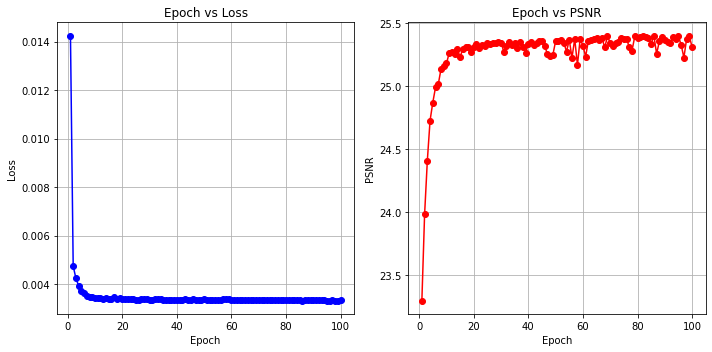

In [21]:
# Plot epoch vs loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, marker='o', color='b')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot epoch vs PSNR
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), psnr_values, marker='o', color='r')
plt.title('Epoch vs PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
trained_model_loaded = ESPCN(scale_factor=1, num_channels=3).to(device)
trained_model_loaded.load_state_dict(torch.load(pthname))


<All keys matched successfully>

/scratch/16353640/ipykernel_304200/3442098758.py:55: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)


1
2
3
4
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


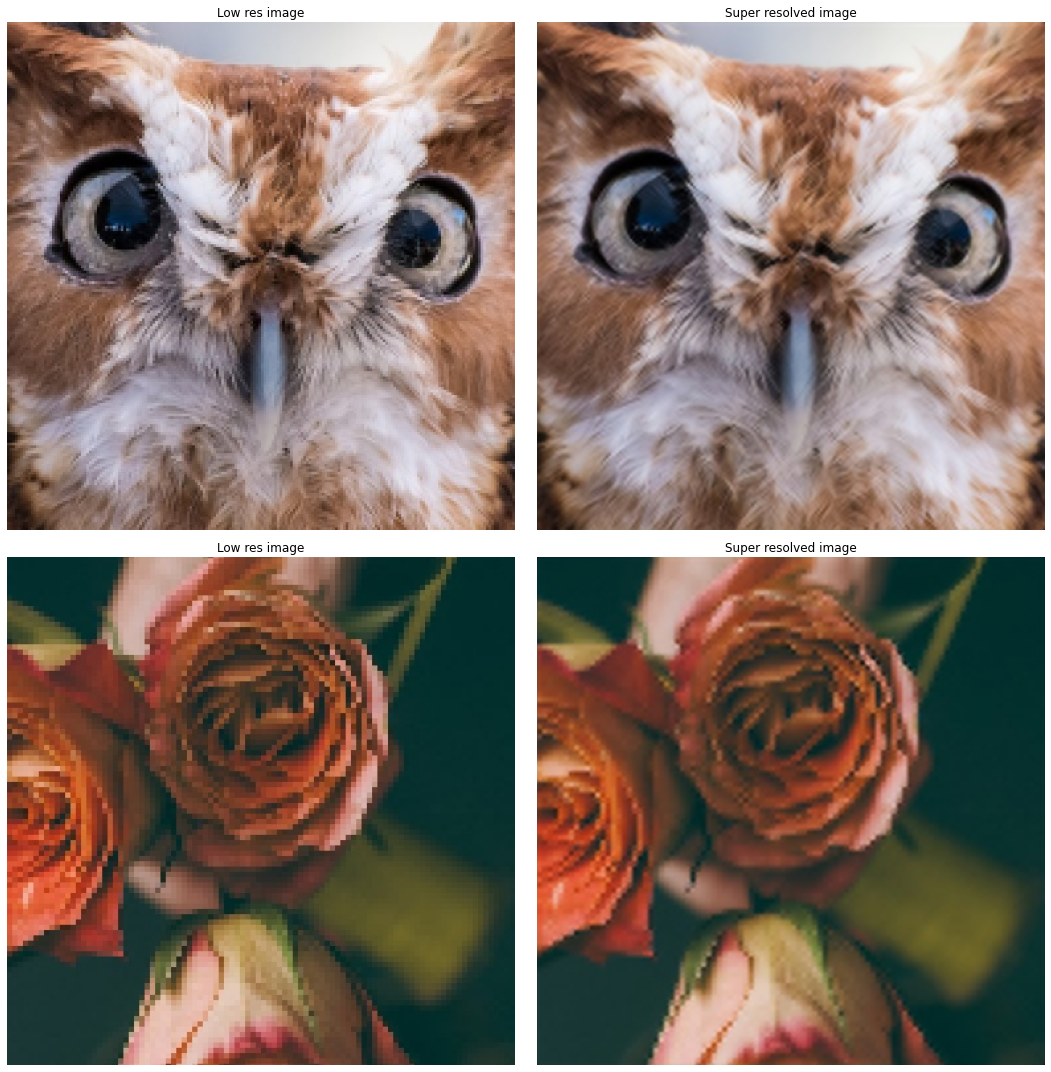

7


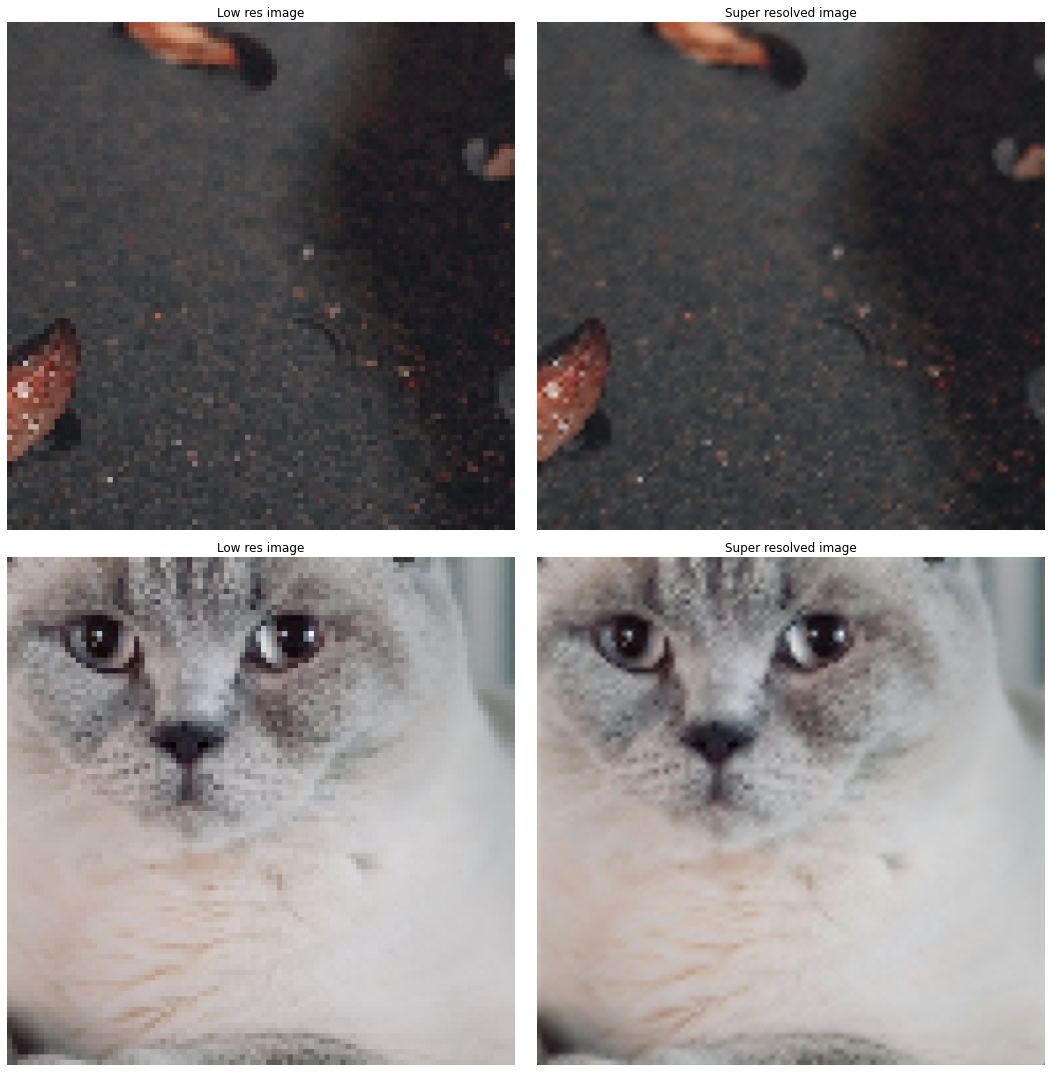

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


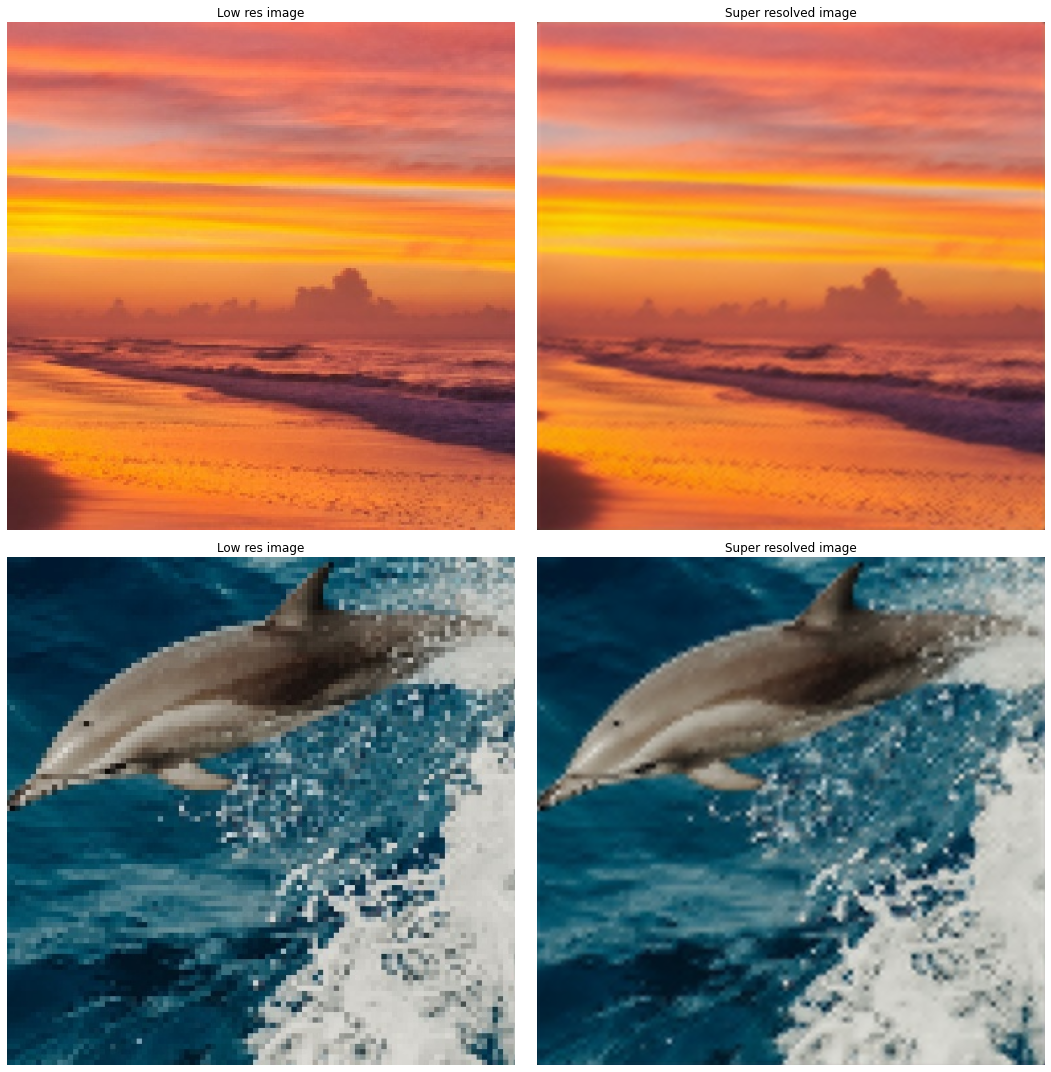

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


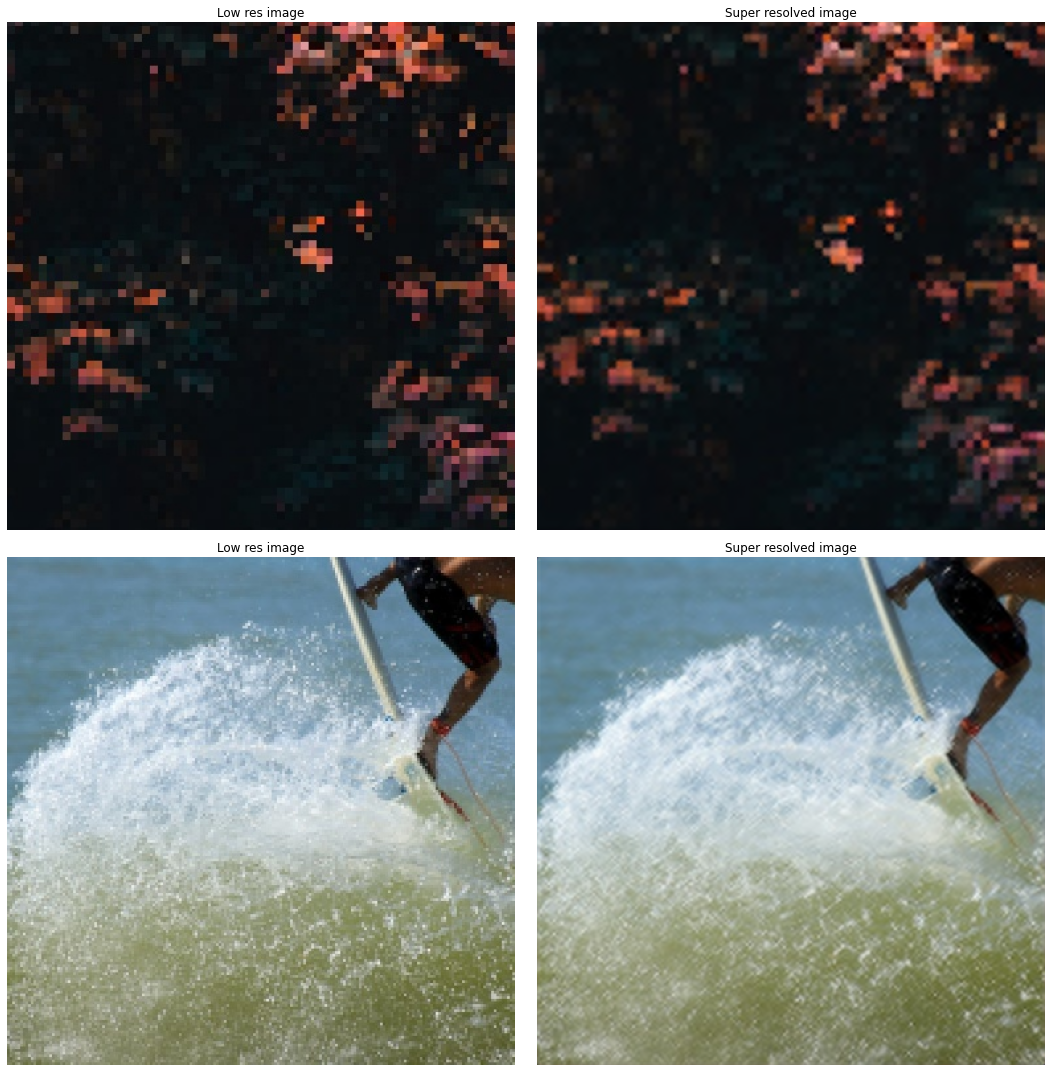

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


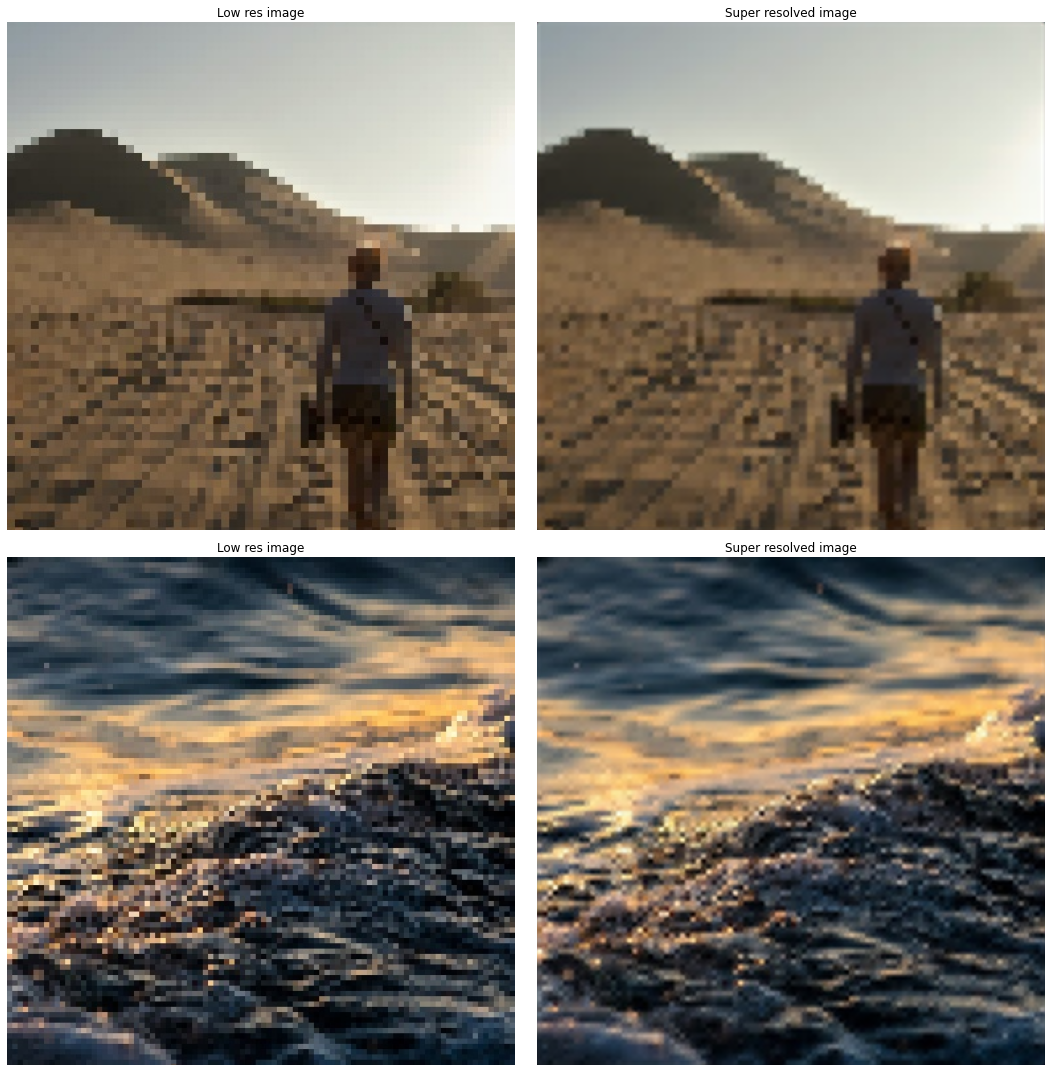

PSNR value for testing dataset is : 24.762762940139957
SSIM value for testing dataset is : 0.7852912147839864


In [32]:
test_model(trained_model_loaded, test_loader)

In [24]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-20/metadata
